# Download the Dataset

Download the dataset from this link: https://www.kaggle.com/shanwizard/modest-museum-dataset

## Dataset Description

Description of the contents of the dataset can be found here: https://shan18.github.io/MODEST-Museum-Dataset

### Mount Google Drive (Works only on Google Colab)

For running the notebook on Google Colab, upload the dataset into you Google Drive and execute the two cells below

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzip the data from Google Drive into Colab

In [0]:
!unzip -qq '/content/gdrive/My Drive/modest_museum_dataset.zip' -d .

### Check GPU

In [0]:
!nvidia-smi

Mon May 25 05:21:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Packages

In [0]:
!pip install -r requirements.txt

# Import Packages

In [0]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import torch

from PIL import Image
from tensornet.data import MODESTMuseum
from tensornet.utils import initialize_cuda, plot_metric
from tensornet.model import DSResNet
from tensornet.model.optimizer import sgd
from tensornet.engine import LRFinder
from tensornet.engine.ops import ModelCheckpoint, TensorBoard
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau
from loss import RmseBceDiceLoss, SsimDiceLoss
from learner import ModelLearner

# Set Seed and Get GPU Availability

In [0]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


# Data Visualization

In [0]:
DATASET_PATH = 'modest_museum_dataset'

# Common parameter values for the dataset
dataset_params = dict(
    cuda=cuda,
    num_workers=16,
    path=DATASET_PATH,
    hue_saturation_prob=0.25,
    contrast_prob=0.25,
)

In [0]:
%%time
# Create dataset
dataset = MODESTMuseum(
    train_batch_size=1,
    val_batch_size=1,
    **dataset_params
)

CPU times: user 6.64 s, sys: 377 ms, total: 7.01 s
Wall time: 7.01 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


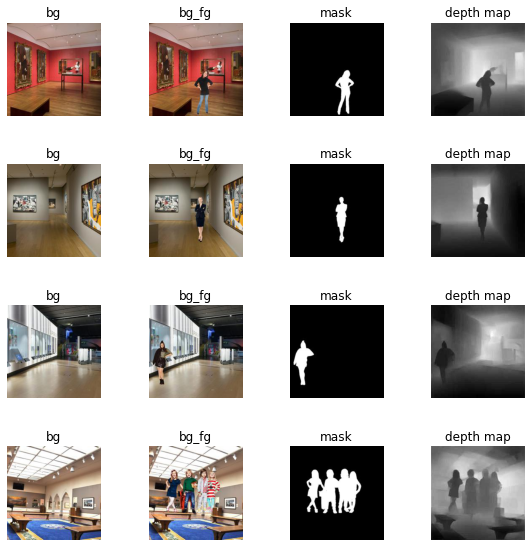

In [0]:
# Set number of data-points to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))

    # Background
    axs[i][0].axis('off')
    axs[i][0].set_title('bg')
    axs[i][0].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg'],
        transpose=True, data_type='bg'
    ))

    # Background-Foreground
    axs[i][1].axis('off')
    axs[i][1].set_title('bg_fg')
    axs[i][1].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg_fg'],
        transpose=True, data_type='bg_fg'
    ))

    # Mask
    axs[i][2].axis('off')
    axs[i][2].set_title('mask')
    axs[i][2].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_mask'],
        transpose=True, data_type='bg_fg_mask'
    ).squeeze(), cmap='gray')

    # Depth Map
    axs[i][3].axis('off')
    axs[i][3].set_title('depth map')
    axs[i][3].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_depth_map'],
        transpose=True, data_type='bg_fg_depth_map'
    ).squeeze(), cmap='gray')

# Model Architecture and Summary

In [0]:
%%time
model = DSResNet().to(device)
model.summary({
    k: v for k, v in dataset.image_size.items() if k in ['bg', 'bg_fg']
})

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]              64
            Conv2d-2         [-1, 16, 224, 224]             448
              ReLU-3         [-1, 16, 224, 224]               0
       BatchNorm2d-4         [-1, 16, 224, 224]              32
            Conv2d-5         [-1, 16, 224, 224]           2,320
              ReLU-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
   DoubleConvBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
  ResEncoderBlock-10  [[-1, 16, 112, 112], [-1, 16, 224, 224]]               0
           Conv2d-11         [-1, 32, 112, 112]             544
           Conv2d-12         [-1, 32, 112, 112]           4,640
             ReLU-13         [-1, 32, 112, 112]               0
      BatchNorm2d-14    

# Model Training and Validation

## Setup Tensorboard

In [0]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

## Images setup
- Some images are selected at random from the validation dataset. The model will make predictions on these images after every epoch.
- This will help in gaining insights as to how is the model learning.

In [0]:
%%time
img_idxes = random.sample(range(len(dataset.val_data)), 32)

# Prepare Images
images = {
    'bg': dataset.val_data[img_idxes[0]][0]['bg'].unsqueeze(0),
    'bg_fg': dataset.val_data[img_idxes[0]][0]['bg_fg'].unsqueeze(0)
}

for idx in img_idxes[1:]:
    images['bg'] = torch.cat((
        images['bg'], dataset.val_data[idx][0]['bg'].unsqueeze(0)
    ), 0)
    images['bg_fg'] = torch.cat((
        images['bg_fg'], dataset.val_data[idx][0]['bg_fg'].unsqueeze(0)
    ), 0)

CPU times: user 875 ms, sys: 53.6 ms, total: 929 ms
Wall time: 504 ms


#### Create Directory for Saving Model Weights

In [0]:
!mkdir checkpoints

## Training

The model training will happen in multiple phases. First the model will be trained on smaller image sizes and then gradually it will be trained on large image sizes.

In [0]:
# Create model
model = DSResNet().to(device)

# Create loss function
criterion = SsimDiceLoss()

# Create optimizer
optimizer = sgd(model, learning_rate=0.01, momentum=0.9)

In [0]:
# Setup Reduce LR on Plateau
scheduler = reduce_lr_on_plateau(
    optimizer, patience=2, verbose=True, min_lr=1e-6
)

# Setup Model Checkpoint
checkpoint = ModelCheckpoint(
    'checkpoints', monitor='val_rmse', mode='max',
    save_best_only=False, verbose=1
)

# Setup Tensorboard
tensorboard = TensorBoard('logs', images.copy(), device)

### Image Size: 96x96

Setting up dataset

In [0]:
%%time
# Create dataset
dataset = MODESTMuseum(
    train_batch_size=256,
    val_batch_size=256,
    resize=(96, 96),
    **dataset_params
)

# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

CPU times: user 6.77 s, sys: 477 ms, total: 7.25 s
Wall time: 7.24 s


Updating learner

In [0]:
%%time
# Create Learner
epochs = 3

learner = ModelLearner(
    train_loader, optimizer, criterion, device=device,
    epochs=epochs, val_loader=val_loader,
    callbacks=[scheduler, checkpoint, tensorboard],
    metrics=[['rmse'], ['iou']],
    record_train=True
)
model.set_learner(learner)

CPU times: user 1.61 s, sys: 234 ms, total: 1.85 s
Wall time: 1.85 s


Training model

In [0]:
# Model Training
model.fit()

Epoch 1:
1094/1094 [========] - 841s 769ms/step - loss: 0.3379 - 0 - rmse: 0.0733 - 1 - iou: 0.6156
Validation set (took 3 minutes, 46 seconds): Average loss: 0.0007, rmse: 0.025, iou: 0.869

Saving model to checkpoints/model-epoch_1.pt

Epoch 2:
1094/1094 [========] - 839s 767ms/step - loss: 0.1659 - 0 - rmse: 0.0251 - 1 - iou: 0.8695
Validation set (took 3 minutes, 26 seconds): Average loss: 0.0006, rmse: 0.022, iou: 0.883

Saving model to checkpoints/model-epoch_2.pt

Epoch 3:
1094/1094 [========] - 839s 767ms/step - loss: 0.1441 - 0 - rmse: 0.0221 - 1 - iou: 0.8804
Validation set (took 3 minutes, 27 seconds): Average loss: 0.0005, rmse: 0.022, iou: 0.887

Saving model to checkpoints/model-epoch_3.pt



### Outputs after 3rd Epoch

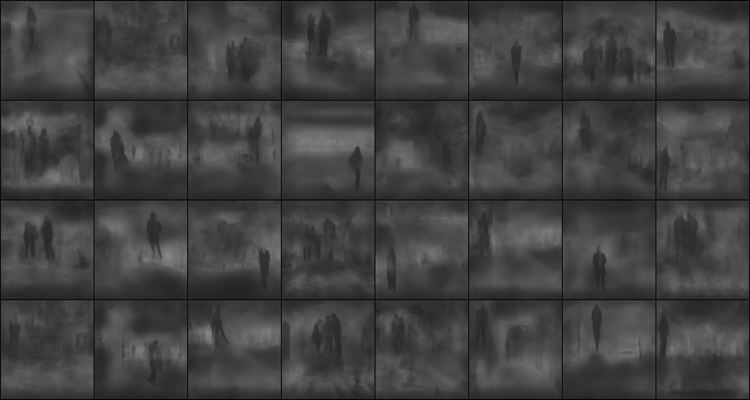

In [18]:
Image.open('logs/images/0_prediction_epoch_3.jpeg').resize((750, 400))

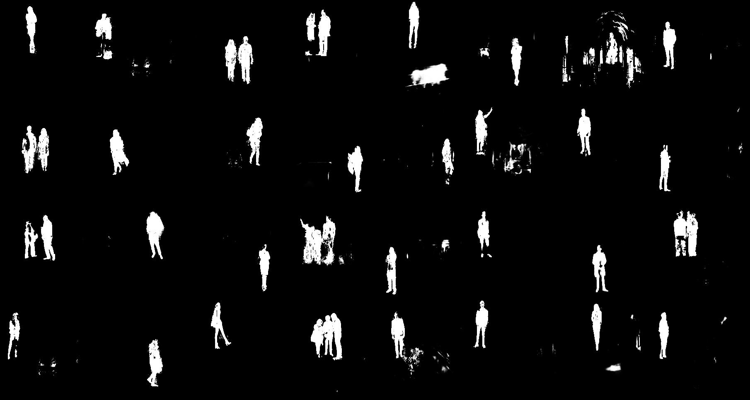

In [17]:
Image.open('logs/images/1_prediction_epoch_3.jpeg').resize((750, 400))

In [0]:
}from torchvision.utils import make_grid

### Image Size: 160x160

Setting up dataset

In [0]:
%%time
# Create dataset
dataset = MODESTMuseum(
    train_batch_size=128,
    val_batch_size=128,
    resize=(160, 160),
    **dataset_params
)

# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

Updating learner

In [0]:
# Update learner with the new dataset
model.learner.train_loader = train_loader
model.learner.val_loader = val_loader
model.learner.epochs = 5

Training model

In [0]:
# Model Training
model.fit(start_epoch=4)

Epoch 4:
1094/1094 [========] - 842s 769ms/step - loss: 0.1325 - 0 - rmse: 0.0210 - 1 - iou: 0.8846
Validation set (took 3 minutes, 39 seconds): Average loss: 0.0005, rmse: 0.019, iou: 0.89

Saving model to checkpoints/model-epoch_4.pt

Epoch 5:
1094/1094 [========] - 846s 773ms/step - loss: 0.1267 - 0 - rmse: 0.0200 - 1 - iou: 0.8870
Validation set (took 3 minutes, 26 seconds): Average loss: 0.0005, rmse: 0.019, iou: 0.892

Saving model to checkpoints/model-epoch_5.pt

Epoch 6:
1094/1094 [========] - 840s 768ms/step - loss: 0.1205 - 0 - rmse: 0.0190 - 1 - iou: 0.8890
Validation set (took 3 minutes, 28 seconds): Average loss: 0.0005, rmse: 0.02, iou: 0.893

Saving model to checkpoints/model-epoch_6.pt

Epoch 7:
1094/1094 [========] - 843s 770ms/step - loss: 0.1195 - 0 - rmse: 0.0190 - 1 - iou: 0.8900
Validation set (took 3 minutes, 35 seconds): Average loss: 0.0004, rmse: 0.018, iou: 0.894

Saving model to checkpoints/model-epoch_7.pt

Epoch 8:
1094/1094 [========] - 844s 772ms/step - 

### Outputs after 8th Epoch

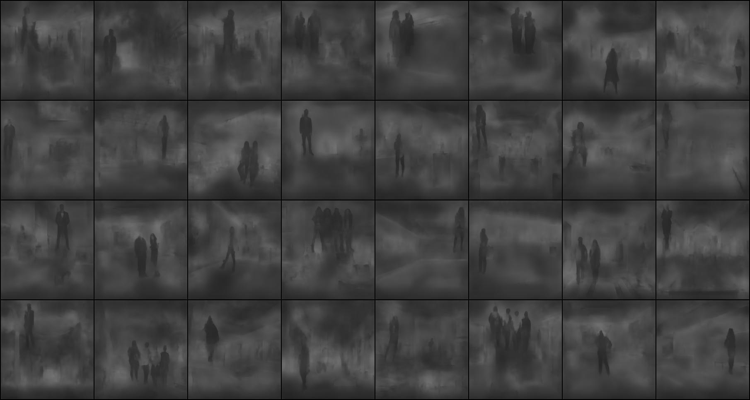

In [19]:
Image.open('logs/images/0_prediction_epoch_8.jpeg').resize((750, 400))

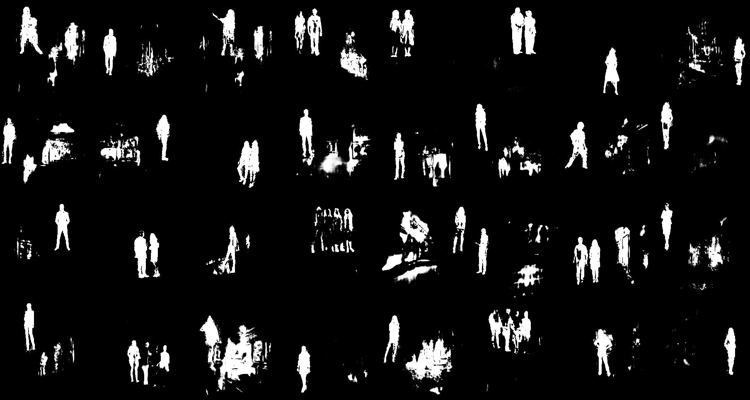

In [23]:
Image.open('upload/1_prediction_epoch_8.jpeg').resize((750, 400))

# Results

Validation Loss

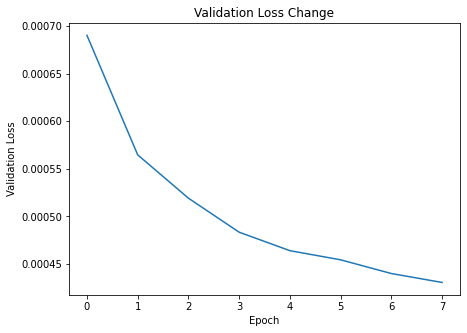

In [0]:
plot_metric(model.learner.val_losses, 'Validation Loss')

RMSE

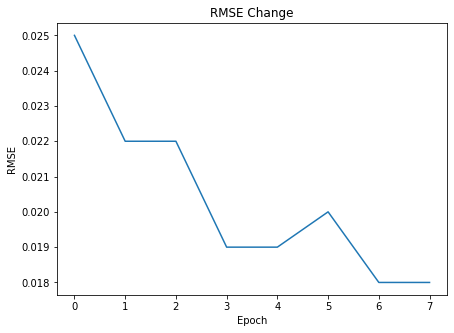

In [0]:
plot_metric(model.learner.val_metrics[0]['rmse'], 'RMSE')

IoU

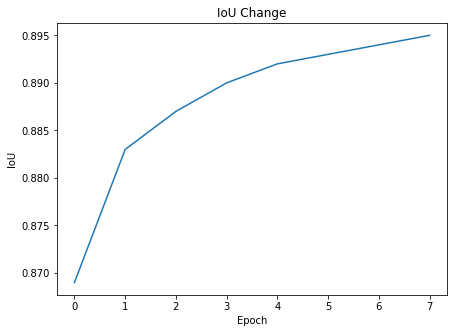

In [0]:
plot_metric(model.learner.val_metrics[1]['iou'], 'IoU')